<p style="font-size:40px">Qubit</p>

A qubit is a quantum bit. It is a two-level system (say, 0 or 1) but here unlike the classical case the situation is more rich in that the state of the system can be in superposition of both bits. If $|0\rangle,\,|1\rangle$ are the two basis states of the quibt, then the general state $|\psi\rangle$ of the system is given by what is called the superposition of the two bits,
$$|\psi\rangle = c_1|0\rangle + c_2|1\rangle,$$
where $c_1$ and $c_2$ are complex numbers. The state is interpreted to encode probability of measurement outcome. An observable is defined to be a *hermitian operator* that acts on the state space or Hilbert space of the system. The measurement outcomes of an obserable are the eigenvalues of the observable operator. If $A$ is an observable operator, then the eigenvalue equation is
$$A|a\rangle = a|a\rangle.$$
The possible eigenvalues $a$ are the possible values of measurement outcome of the observable $A$.

Upon measurement, the probability of measuring $a$ is postulated to be given by the square of the inner product of the two states
$$P(a) = |\langle a|\psi\rangle|^2.$$
Obviously, if the observable is such that $|\psi\rangle$ is its eigenstate then, probability of measurement value corresponding to state $|\psi\rangle$ is 1. Consequently,
$$|\langle \psi|\psi\rangle|^2 = |a|^2+|b|^2 = 1.$$
This leads us to write a general state as
$$|\psi\rangle = e^{i\theta_1}\cos\phi|0\rangle + e^{i\theta_2}\sin\phi|1\rangle.$$
The overall phase is not relevant as the probability is unchanged. So, we can write a general state as
$$|\psi\rangle = \cos\phi|0\rangle + e^{i\theta}\sin\phi|1\rangle.$$
The hilbert space is two dimensional (in complex dimension) described by four real parameters. However, as we see, the physical state has only two independent degrees of freedom.

A two qubit system is represented as
$$|\psi\rangle = c_1|00\rangle + c_2|10\rangle + c_3|10\rangle + c_4|11\rangle.$$
The hilbert state is tensor product of two copies of single-qubit hilbert space. We see it has 8 real parameters. However, as before normalization and overall phase reduce the independent parameters to 6. 

Given an input data that contains information about the state of a qubit, the model predicts the measure of probability for the qubit to be found in a particular state that is passed to the network. The variation of root-mean-squared with the latent layer size provides information about the number of independent dimensions of the state.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import datasets

In [3]:
from model import ScNN

# Data Generation Methods

Given a state of a qubit, the state can also be parameterized by its projection probability to a set of states. This parameterization is suitable for experimental setup. Ideally, one would require as many projection states as the dimension of the state. However, in experimental setup one does not know if a given set of probabilities correspond to a set of complete states. In fact, one can have the situation where the given set of projection states does not span the full state space of the qubit in which case the input data does not contain full information about the state of the qubit. In this case, we will see the network is not able to extract the dimension of the qubit.

In [4]:
"""Random complex 1-D array generator.
"""
def randomComplex(samples=10):
    #array of type complex
    c_number = np.empty(shape=(samples,1), dtype='complex')
    #generates random arrays for real and imaginary part of the complex array
    real_imag = np.random.uniform(low=-1, high=1, size=(samples,2))
    
    #calculates the norm using the real and imaginary parts stored in each row of the array
    #norms = np.linalg.norm(real_imag, axis=1).reshape(-1,1)
    #normalize the complex numbers
    #real_imag = real_imag/norms

    c_number.real = real_imag[:,0:1]
    c_number.imag = real_imag[:,1:2]

    return c_number

In [5]:
"""Random qubit states generator.
   The states are represented in the computational basis states {|0>, |1>}.
   The coefficients of the states are stored row-wise.
"""

def qubitStates(num_qubits=1, num_states=10):
    #rows store coefficients, which are (2**num_qubits) in number
    states = np.empty(shape=(num_states, 2**num_qubits), dtype='complex')
    #loop over each column
    for i in range(2**num_qubits):
        states[:,i:i+1] = randomComplex(samples=num_states)

    #absolute values of the states
    moduli = np.sqrt(np.einsum('ij,ij->i', np.conj(states), states).reshape(-1,1))
    #normalize the states
    states = states/moduli
    
    return states

In [6]:
"""Calculates the probability of the projection of the qubit state to a state corresponding to a projective measurement
"""

def projectionProbability(state, projection_state):
    #calculates the overlap of the two states
    prob = np.dot(np.conj(state), projection_state)
    #calculates the probability of the projection from the overlap
    prob = prob*np.conj(prob)
    
    return prob

In [153]:
"""Given the measurement states for input and question, the function generates pairs of random qubit states.
   The pair consists of an input state and a state whose probability is to be predicted.
   The input state is parameterized by the probabilities of the projections on the input measurement states,
   and that question state using question measurement states.
"""

def prepareData(input_measurement_states, question_measurement_states, num_qubits=1, normalized=True, samples=5000):
    if not normalized:
        input_sum_square = (input_measurement_states.conj()*input_measurement_states).sum(axis=0).reshape(1,-1)
        question_sum_square = (question_measurement_states.conj()*question_measurement_states).sum(axis=0).reshape(1,-1)

        input_measurement_states = input_measurement_states/np.sqrt(input_sum_square)
        question_measurement_states = question_measurement_states/np.sqrt(question_sum_square)
    #the input states
    qubit_states = qubitStates(num_qubits=num_qubits, num_states=samples)
    #the states whose probabilities are to be predicted
    question_states = qubitStates(num_qubits=num_qubits, num_states=samples)

    #get the probabilities of the projections of the input state to the input measurement states
    input_states_probs = projectionProbability(qubit_states, input_measurement_states)
    #get the probabilities of the projections of the question state to the question measurement states
    question_states_probs = projectionProbability(question_states, question_measurement_states)
    #calculate the probability of the projection of the input state to the question state
    answer_probs = np.einsum('ij,ij->i', qubit_states, question_states).reshape(-1,1)
    answer_probs = answer_probs*np.conj(answer_probs)

    return input_states_probs, question_states_probs, answer_probs

In [35]:
def orthogonalize(arr):
    vecs = arr.copy().astype(np.complex128)
    num_vec, dim = vecs.shape
    for i in range(num_vec):
        pre_norm = np.linalg.norm(vecs[i:i+1, :])
        for j in range(0, i):
            vecs[i:i+1,:] -= vecs[j:j+1,:]*np.vdot(vecs[j:j+1,:], vecs[i:i+1,:])
        post_norm = np.linalg.norm(vecs[i:i+1, :])
        if post_norm/pre_norm >= 1.e-4:
            vecs[i:i+1, :] /= post_norm

    return vecs

# Model Creation and Validation accuracy Methods

In [8]:
"""
"""

def createModels(input_probs, question_probs, answer_probs, latent_size_array=np.arange(start=1, stop=6)):
    epochs = 250
    batch_size = 500
    learning_rate = 1.0e-3

    models = []
    
    for i, latent_size in enumerate(latent_size_array):
        print("\n-----------------------------latent layer size: " + str(latent_size) + "-----------------------------\n")
        qubit = ScNN(input_size=10, encoder_layer=[100,100], latent_size=latent_size, question_size=10, decoder_layer=[100, 100], output_size=1, beta_rec=500., beta_kl=1.0e-1)
        
        qubit.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
        qubit.fit({'time_series': input_probs.real, 't_question': question_probs.real, 'answer': answer_probs.real}, batch_size=batch_size, epochs=epochs)
        models.append(qubit)
        
    return models

In [258]:
def recompile(models, input_probs, question_probs, answer_probs, epochs=250, batch_size=500, learning_rate=1.0e-3):
    size = len(models)

    for i in range(size):
        print("\n-----------------------------latent layer size: " + str(i+1) + "-----------------------------\n")
        models[i].compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
        models[i].fit({'time_series': input_probs.real, 't_question': question_probs.real, 'answer': answer_probs.real}, batch_size=batch_size, epochs=epochs)

In [9]:
def validateModels(models, input_probs, question_probs, answer_probs, latent_size_array):
    mean_sq_error = np.empty(shape=(len(latent_size_array),1))

    for i in range(len(latent_size_array)):
        mu, logvar, z, probs_prediction = models[i].predict([input_probs.real, question_probs.real])
        mean_sq_error[i,0] = ((probs_prediction - answer_probs)**2).mean().real

    return mean_sq_error

# One Qubit

## Generating Dataset

In [31]:
input_measurement_states_1q = qubitStates(num_qubits=1, num_states=10).T
question_measurement_states_1q = qubitStates(num_qubits=1, num_states=10).T
print(input_measurement_states_1q.shape)
print(question_measurement_states_1q.shape)

(2, 10)
(2, 10)


### Tomographically complete states

In [32]:
train_samples_1q = 100000
input_probs_1q_train, question_probs_1q_train, answer_probs_1q_train = prepareData(input_measurement_states_1q, question_measurement_states_1q, num_qubits=1, samples=train_samples_1q)

print(input_probs_1q_train.shape)
print(question_probs_1q_train.shape)
print(answer_probs_1q_train.shape)

(100000, 10)
(100000, 10)
(100000, 1)


In [33]:
test_samples_1q = 5000
input_probs_1q_test, question_probs_1q_test, answer_probs_1q_test = prepareData(input_measurement_states_1q, question_measurement_states_1q, num_qubits=1, samples=test_samples_1q)

print(input_probs_1q_test.shape)
print(question_probs_1q_test.shape)
print(answer_probs_1q_test.shape)

(5000, 10)
(5000, 10)
(5000, 1)


### Tomographically incomplete states

In [34]:
input_measurement_states_1q_tom_inc = input_measurement_states_1q.copy()
input_measurement_states_1q_tom_inc.imag = 0
print(input_measurement_states_1q_tom_inc.shape)

(2, 10)


In [22]:
orthogonal_input_measurement_states = orthogonalize(input_measurement_states_1q.T).T
orthogonal_input_measurement_states.shape

(2, 10)

In [24]:
orthogonal_input_measurement_states_1q = orthogonal_input_measurement_states_1q[:,0:1]
orthogonal_input_measurement_states_1q

array([[ 0.50911116-0.40145371j],
       [-0.5494514 +0.52701414j]])

In [25]:
input_probs_1q_tom_inc_train, question_probs_1q_tom_inc_train, answer_probs_1q_tom_inc_train = prepareData(input_measurement_states_1q_tom_inc, question_measurement_states_1q, num_qubits=1, samples=train_samples_1q)

print(input_probs_1q_train.shape)
print(question_probs_1q_train.shape)
print(answer_probs_1q_train.shape)

(100000, 10)
(100000, 10)
(100000, 1)


In [35]:
input_probs_1q_tom_inc_test, question_probs_1q_tom_inc_test, answer_probs_1q_tom_inc_test = prepareData(input_measurement_states_1q_tom_inc, question_measurement_states_1q, num_qubits=1, samples=test_samples_1q)

print(input_probs_1q_tom_inc_test.shape)
print(question_probs_1q_test.shape)
print(answer_probs_1q_test.shape)

(5000, 10)
(5000, 10)
(5000, 1)


## Train Model

Each sample in the training consists of a time series of 50 positions of pendulum, the prediction time as a question and the corresponding answer to the question, which is the position o fthe pendulum.

A large sample is generated by varying the frequency and the damping parameter fo the pendulum. The parameters are randomly chosen in the specified range.

In [37]:
#(self, input_size=50, encoder_layer=[70, 70], latent_size=3, question_size=1,| decoder_layer=[70, 70], output_size=1, beta_rec=500., beta_kl=1., target_sigma=0.1, **kwargs)
qubit = ScNN(input_size=10, encoder_layer=[100,100], latent_size=3, question_size=10, decoder_layer=[100, 100], output_size=1, beta_rec=500., beta_kl=1.0e-1)

In [38]:
latent_sizes_1q = np.arange(start=1, stop=6)
models_1q = createModels(input_probs_1q_train, question_probs_1q_train, answer_probs_1q_train, latent_sizes_1q)


-----------------------------latent layer size: 1-----------------------------

Epoch 1/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 1.4635 - reconstruction_loss: 52.6456 - total_loss: 54.1091
Epoch 2/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 1.7618 - reconstruction_loss: 26.3245 - total_loss: 28.0863
Epoch 3/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.7837 - reconstruction_loss: 26.0738 - total_loss: 26.8576
Epoch 4/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.6058 - reconstruction_loss: 26.1400 - total_loss: 26.7458
Epoch 5/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.4931 - reconstruction_loss: 26.0691 - total_loss: 26.5622
Epoch 6/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 0.4348 - reconstruction_loss: 26.0373 - total_loss: 26.4721
Epoch 7/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 0.4178 - reconstruction_loss: 25.8042 - total_loss: 26.2219
Epoch 8/250
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [ ]:
"""epochs = 100
batch_size = 500
learning_rate = 1.0e-3

qubit.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
qubit.fit({'time_series': input_probs_1q_train.real, 't_question': question_probs_1q_train.real, 'answer': answer_probs_1q_train.real}, batch_size=batch_size, epochs=epochs)
"""

In [ ]:
"""
epochs_tom_inc = 100
batch_size_tom_inc = 500
learning_rate_tom_inc = 1.0e-3

qubit_tom_inc.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tom_inc))
qubit_tom_inc.fit({'time_series': input_probs_1q_tom_inc_train.real, 't_question': question_probs_1q_tom_inc_train.real, 'answer': answer_probs_1q_tom_inc_train.real}, batch_size=batch_size_tom_inc, epochs=epochs_tom_inc)
"""

In [21]:
#saving the model to local storage
for i in range(len(latent_sizes_1q)):
    models_1q[i].save("qubit_1q_" + str(i+1) + ".keras")

## Validating the model

The test sample is similarly generated. The answer to the question is predicted by the model for each sample.

In [ ]:
#loading the model from local storage
models_1q = []
for i in range(len(latent_sizes_1q)):
    models_1q.append(tf.keras.models.load_model("qubit_1q_" + str(i+1) + ".keras"))

In [ ]:
mean_sq_errors_1q = validateModels(models_1q, input_probs_1q_test, question_probs_1q_test, answer_probs_1q_test, latent_sizes_1q)
root_mean_sq_errors_1q = np.sqrt(mean_sq_errors_1q)

In [83]:
mean_sq_errors_1q_tom_inc = validateModels(models_1q, input_probs_1q_tom_inc_test, question_probs_1q_test, answer_probs_1q_test, latent_sizes_1q)
root_mean_sq_errors_1q_tom_inc = np.sqrt(mean_sq_errors_1q_tom_inc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


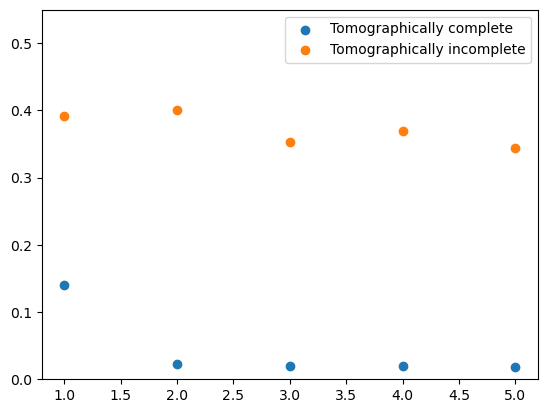

In [103]:
latent_sizes_1q.reshape(-1,1)
plt.ylim(0,0.55)
plt.scatter(latent_sizes_1q, root_mean_sq_errors_1q)
plt.scatter(latent_sizes_1q, root_mean_sq_errors_1q_tom_inc)
plt.legend(['Tomographically complete', 'Tomographically incomplete'], loc='upper right')
plt.show()

# Two Qubit

## Generating Dataset

In [237]:
num_qubits = 2
#generate two qubit states. Probabilities corresponding to the projection of the input state to these states will be the input given to the model
input_measurement_states_2q = qubitStates(num_qubits=num_qubits, num_states=30).T
#set of states to parameterize the question state
question_measurement_states_2q = qubitStates(num_qubits=num_qubits, num_states=30).T

print(input_measurement_states_2q.shape)
print(question_measurement_states_2q.shape)

(4, 30)
(4, 30)


### Tomographically complete states

In [11]:
train_samples_2q = 500000
#the function generates random input state and calculates the projection probabilities of the generated input state to the given set of input measurement states
#and also calculates the projection probabilities of the input state to the question measurement state and its corresponding projectionprobability
input_probs_2q_train, question_probs_2q_train, answer_probs_2q_train = prepareData(input_measurement_states_2q, question_measurement_states_2q, num_qubits=num_qubits, samples=train_samples_2q)

print(input_probs_2q_train.shape)
print(question_probs_2q_train.shape)
print(answer_probs_2q_train.shape)

(500000, 30)
(500000, 30)
(500000, 1)


In [12]:
test_samples_2q = 10000
#generates the test samples of input states, the measurement state and its probvability
input_probs_2q_test, question_probs_2q_test, answer_probs_2q_test = prepareData(input_measurement_states_2q, question_measurement_states_2q, num_qubits=num_qubits, samples=test_samples_2q)

print(input_probs_2q_test.shape)
print(question_probs_2q_test.shape)
print(answer_probs_2q_test.shape)

(10000, 30)
(10000, 30)
(10000, 1)


### Tomographically incomlete states

The tomographically incomplete states are generated by using the input states and making its imaginary part to be zero so that the input state lies in the real subspace of the complex hilbert space

In [195]:
Q, R = np.linalg.qr(input_measurement_states_2q)

In [197]:
Q

array([[-0.43479864+0.07832613j, -0.73297659-0.35976239j,
        -0.34033696+0.03009272j, -0.13371705+0.05929959j],
       [ 0.01302359-0.66931865j, -0.17279378+0.2208056j ,
        -0.03161047+0.42556902j, -0.13656112-0.52198944j],
       [ 0.27029441-0.01391938j,  0.25616495-0.1071141j ,
        -0.47153034+0.42903099j, -0.52451062+0.41004077j],
       [ 0.52689246-0.07608952j, -0.41298625-0.08397613j,
         0.47006295-0.27164195j, -0.48609742+0.08913959j]])

In [205]:
orthogonal_input_measurement_states_2q

array([[ 0.43479864-0.07832613j,  0.73297659+0.35976239j,
         0.34033696-0.03009272j,  0.13371705-0.05929959j],
       [-0.01302359+0.66931865j,  0.17279378-0.2208056j ,
         0.03161047-0.42556902j,  0.13656112+0.52198944j],
       [-0.27029441+0.01391938j, -0.25616495+0.1071141j ,
         0.47153034-0.42903099j,  0.52451062-0.41004077j],
       [-0.52689246+0.07608952j,  0.41298625+0.08397613j,
        -0.47006295+0.27164195j,  0.48609742-0.08913959j]])

In [246]:
#take the input measurement states
orthogonal_input_measurement_states_2q = orthogonalize(input_measurement_states_2q.T).T

print(orthogonal_input_measurement_states_2q.shape)

(4, 30)


In [247]:
#only the first four states are non-vanshing
#discard other states
orthogonal_input_measurement_states_2q = orthogonal_input_measurement_states_2q[:,0:4]

In [168]:
#takes a set of states and the dimension of the subspace of the linear combination to be returned
def superpositionStates(input_states, samples=30, subspace_dim=2, coeff='complex'):
    #get the original dimension of the input state
    dim = input_states.shape[0]
    #create an array for a total of 'samples' number of linear combinations
    input_states_tom_inc = np.zeros(dim*samples, dtype=complex).reshape(dim, samples)

    for i in range(samples):
        #get random coefficients to take the linear combinationabs
        #number of coefficients is the dimension of the subspace required
        if coeff=='complex':
            random_coeff = randomComplex(subspace_dim).T
        else:
            random_coeff = np.random.uniform(low=-1,high=1,size=(1,subspace_dim))
        #normalize the coefficients
        random_coeff = random_coeff/np.sqrt((random_coeff.conj()*random_coeff).sum())
        #take the linear combination for each set of random coefficients
        input_states_tom_inc[:,i:i+1] = (input_states[:,0:subspace_dim]*random_coeff).sum(axis=1).reshape(-1,1)

    return input_states_tom_inc

In [219]:
input_measurement_states_2q_2dim_tom_inc = superpositionStates(orthogonal_input_measurement_states_2q, samples=30, subspace_dim=2, coeff='real')

In [220]:
#get the parameterized incomplete input and the question states and the question state probability as the answer
input_probs_2q_2dim_tom_inc_test, question_probs_2q_2dim_tom_inc_test, answer_probs_2q_2dim_tom_inc_test = prepareData(input_measurement_states_2q_tom_inc, question_measurement_states_2q, num_qubits=2, normalized=False, samples=test_samples_2q)

print(input_probs_2q_2dim_tom_inc_test.shape)
print(question_probs_2q_2dim_tom_inc_test.shape)
print(answer_probs_2q_2dim_tom_inc_test.shape)

(10000, 30)
(10000, 30)
(10000, 1)


In [175]:
input_measurement_states_2q_3dim_tom_inc = superpositionStates(orthogonal_input_measurement_states_2q, samples=30, subspace_dim=3, coeff='real')

In [176]:
#get the parameterized incomplete input and the question states and the question state probability as the answer
input_probs_2q_3dim_tom_inc_test, question_probs_2q_3dim_tom_inc_test, answer_probs_2q_3dim_tom_inc_test = prepareData(input_measurement_states_2q_3dim_tom_inc, question_measurement_states_2q, num_qubits=2, samples=test_samples_2q)

print(input_probs_2q_3dim_tom_inc_test.shape)
print(question_probs_2q_3dim_tom_inc_test.shape)
print(answer_probs_2q_3dim_tom_inc_test.shape)

(10000, 30)
(10000, 30)
(10000, 1)


In [248]:
input_measurement_states_2q_4dim_tom_inc = superpositionStates(orthogonal_input_measurement_states_2q, samples=30, subspace_dim=4, coeff='complex')

In [249]:
#get the parameterized incomplete input and the question states and the question state probability as the answer
input_probs_2q_4dim_tom_inc_test, question_probs_2q_4dim_tom_inc_test, answer_probs_2q_4dim_tom_inc_test = prepareData(input_measurement_states_2q_4dim_tom_inc, question_measurement_states_2q, num_qubits=2, normalized=False, samples=test_samples_2q)

print(input_probs_2q_4dim_tom_inc_test.shape)
print(question_probs_2q_4dim_tom_inc_test.shape)
print(answer_probs_2q_4dim_tom_inc_test.shape)

(10000, 30)
(10000, 30)
(10000, 1)


## Train Model

Each sample in the training consists of a set of projection probabilities for the input state (the probabilities may or may not be tomographically complete), a set of projection probabilities for the measurement states, and the probability of finding the input state in the measurement state.

A large sample is generated by varying the input state and the question state.

In [13]:
#(self, input_size=50, encoder_layer=[70, 70], latent_size=3, question_size=1,| decoder_layer=[70, 70], output_size=1, beta_rec=500., beta_kl=1., target_sigma=0.1, **kwargs)
qubit = ScNN(input_size=30, encoder_layer=[300,100], latent_size=3, question_size=30, decoder_layer=[100, 100], output_size=1, beta_rec=500., beta_kl=1.0e-1)

In [ ]:
epochs = 50
batch_size = 500
learning_rate = 1.0e-3

qubit.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
qubit.fit({'time_series': input_probs_2q_train.real, 't_question': question_probs_2q_train.real, 'answer': answer_probs_2q_train.real}, batch_size=batch_size, epochs=epochs)

In [ ]:
#generate a set of latent layer sizes
latent_sizes_2q = np.arange(start=1, stop=10)
#the function creates a set of qubit models for each latent sizes
models_2q = createModels(input_probs_2q_train, question_probs_2q_train, answer_probs_2q_train, latent_sizes_2q)


-----------------------------latent layer size: 1-----------------------------

Epoch 1/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 0.1424 - reconstruction_loss: 20.1366 - total_loss: 20.2789
Epoch 2/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.1332 - reconstruction_loss: 18.3424 - total_loss: 18.4756
Epoch 3/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.1584 - reconstruction_loss: 18.0816 - total_loss: 18.2400
Epoch 4/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.1688 - reconstruction_loss: 17.6184 - total_loss: 17.7872
Epoch 5/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.1552 - reconstruction_loss: 17.4698 - total_loss: 17.6250
Epoch 6/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.1483 - reconstruction_loss: 17.4126 - total_loss: 17.5609
Epoch 7/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.1435 - reconstruction_loss: 17.3093 - total_loss: 17.4528
Epoch 8/250
1000/1000 ━━━━━━━━━━━━━━━

In [ ]:
recompile(models_2q, input_probs_2q_train, question_probs_2q_train, answer_probs_2q_train, epochs=500, learning_rate=1.0e-3)


-----------------------------latent layer size: 1-----------------------------

Epoch 1/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.3153 - reconstruction_loss: 13.5000 - total_loss: 13.8153
Epoch 2/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.3208 - reconstruction_loss: 13.4314 - total_loss: 13.7522
Epoch 3/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 0.3242 - reconstruction_loss: 13.4204 - total_loss: 13.7447
Epoch 4/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 0.3272 - reconstruction_loss: 13.4946 - total_loss: 13.8219
Epoch 5/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 0.3259 - reconstruction_loss: 13.4468 - total_loss: 13.7727
Epoch 6/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 0.3342 - reconstruction_loss: 13.3863 - total_loss: 13.7205
Epoch 7/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 0.3288 - reconstruction_loss: 13.4560 - total_loss: 13.7849
Epoch 8/500
1000/1000 ━━━━━━━━━━━━━━━

In [296]:
recompile(models_2q, input_probs_2q_train, question_probs_2q_train, answer_probs_2q_train, epochs=500, learning_rate=1.0e-4)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1461 - reconstruction_loss: 3.2696 - total_loss: 4.4157
Epoch 422/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1444 - reconstruction_loss: 3.2264 - total_loss: 4.3707
Epoch 423/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1434 - reconstruction_loss: 3.2508 - total_loss: 4.3942
Epoch 424/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1434 - reconstruction_loss: 3.2406 - total_loss: 4.3841
Epoch 425/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1449 - reconstruction_loss: 3.2437 - total_loss: 4.3886
Epoch 426/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1441 - reconstruction_loss: 3.2443 - total_loss: 4.3884
Epoch 427/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.1445 - reconstruction_loss: 3.2432 - total_loss: 4.3876
Epoch 428/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.1451 - reconstruction_loss: 3.2419 - total_loss: 4.3870
Epoch 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.3408 - reconstruction_loss: 1.6115 - total_loss: 2.9522
Epoch 73/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - kl_loss: 1.3463 - reconstruction_loss: 1.6146 - total_loss: 2.9609
Epoch 74/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.3439 - reconstruction_loss: 1.6164 - total_loss: 2.9603
Epoch 75/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.3422 - reconstruction_loss: 1.6111 - total_loss: 2.9533
Epoch 76/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.3445 - reconstruction_loss: 1.6059 - total_loss: 2.9504
Epoch 77/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.3441 - reconstruction_loss: 1.6083 - total_loss: 2.9523
Epoch 78/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.3383 - reconstruction_loss: 1.6094 - total_loss: 2.9477
Epoch 79/500
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 1.3447 - reconstruction_loss: 1.6107 - total_loss: 2.9553
Epoch 80/500


## Validating the model

The test sample is similarly generated. The answer to the question is predicted by the model for each sample.

In [297]:
mu_2q, logvar_2q, z_2q, probs_prediction_2q = qubit.predict([input_probs_2q_test.real, question_probs_2q_test.real])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step


In [298]:
error_2q = ((probs_prediction_2q - answer_probs_2q_test)**2).mean()
print(error_2q.real)

0.01843045900551915


In [299]:
#validate each models against the same test samples by calculating the mean squared error for the answer probabilities
mean_sq_errors_2q = validateModels(models_2q, input_probs_2q_test, question_probs_2q_test, answer_probs_2q_test, latent_sizes_2q)
root_mean_sq_errors_2q = np.sqrt(mean_sq_errors_2q)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step


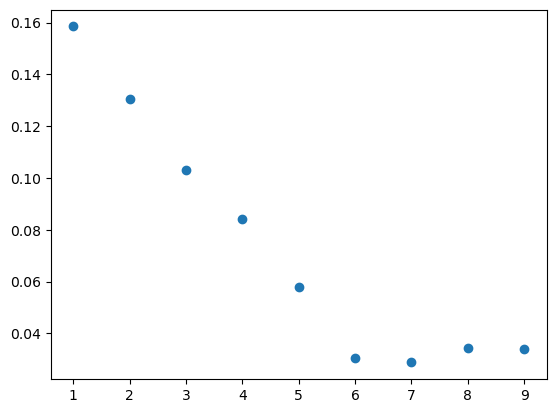

In [300]:
latent_sizes_2q.reshape(-1,1)
plt.scatter(latent_sizes_2q, root_mean_sq_errors_2q)

We see that the root-mean-square keeps decreasing with increasing the number of latent neurons until the number of neurons reached 6 which is sufficient to parmeterize the state as the number of independent parameters are six.

In [301]:
#validate each models against the same test samples by calculating the mean squared error for the answer probabilities
#input_probs_2q_tom_inc_test, question_probs_2q_tom_inc_test, answer_probs_2q_tom_inc_test
mean_sq_errors_2q_2dim_tom_inc = validateModels(models_2q, input_probs_2q_2dim_tom_inc_test, question_probs_2q_2dim_tom_inc_test, answer_probs_2q_2dim_tom_inc_test, latent_sizes_2q)
root_mean_sq_errors_2q_2dim_tom_inc = np.sqrt(mean_sq_errors_2q_2dim_tom_inc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


In [302]:
#validate each models against the same test samples by calculating the mean squared error for the answer probabilities
#input_probs_2q_tom_inc_test, question_probs_2q_tom_inc_test, answer_probs_2q_tom_inc_test
mean_sq_errors_2q_3dim_tom_inc = validateModels(models_2q, input_probs_2q_3dim_tom_inc_test, question_probs_2q_3dim_tom_inc_test, answer_probs_2q_3dim_tom_inc_test, latent_sizes_2q)
root_mean_sq_errors_2q_3dim_tom_inc = np.sqrt(mean_sq_errors_2q_3dim_tom_inc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step


In [303]:
#validate each models against the same test samples by calculating the mean squared error for the answer probabilities
#input_probs_2q_tom_inc_test, question_probs_2q_tom_inc_test, answer_probs_2q_tom_inc_test
mean_sq_errors_2q_4dim_tom_inc = validateModels(models_2q, input_probs_2q_4dim_tom_inc_test, question_probs_2q_4dim_tom_inc_test, answer_probs_2q_4dim_tom_inc_test, latent_sizes_2q)
root_mean_sq_errors_2q_4dim_tom_inc = np.sqrt(mean_sq_errors_2q_4dim_tom_inc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


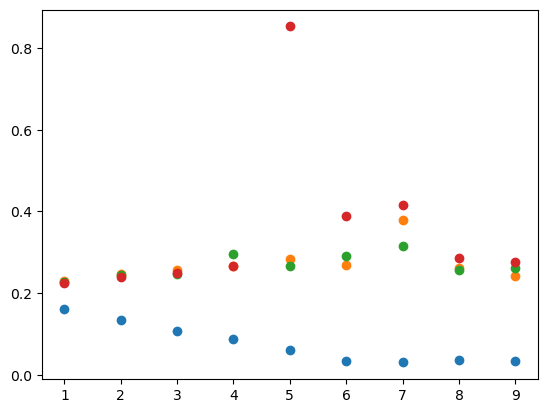

In [283]:
latent_sizes_2q.reshape(-1,1)
plt.scatter(latent_sizes_2q, root_mean_sq_errors_2q)
plt.scatter(latent_sizes_2q, root_mean_sq_errors_2q_2dim_tom_inc)
plt.scatter(latent_sizes_2q, root_mean_sq_errors_2q_3dim_tom_inc)
plt.scatter(latent_sizes_2q, root_mean_sq_errors_2q_4dim_tom_inc)

Here, the input does contain the complete information of the state so the network struggles in answering the probability of the asked state, consequently the rms error does not decrease as the number of latent neurons is increased.

In [21]:
#generate observation data and test samples with a fixed value of spring constant and damping parameter
samples = 200
t_obs = np.linspace(0, 5, 50).reshape(1,-1)
t_ques = np.linspace(0, 10, samples).reshape(-1, 1)
#observation data
x_obs = generateTrajectory(t_obs, 0.5, 5, units=50, samples=1)
#test questions as array of times and the corresponding answer as the position of the pendulum
x_true_ans = generateTrajectory(t_ques, 0.5, 5, units=1, samples=samples)

In [22]:
z_mu = np.zeros(samples*3).reshape(samples, 3)
z_logvar = np.zeros(samples*3).reshape(samples, 3)
z = np.zeros(samples*3).reshape(samples, 3)
#array to store the predicted answers of the model
x_pred_ans = np.zeros(samples).reshape(1,samples)

#generate answer to each questions
z_mu, z_logvar, z, x_pred_ans = pendulum.predict([np.broadcast_to(x_obs, shape=(samples, 50)), t_ques])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


[]

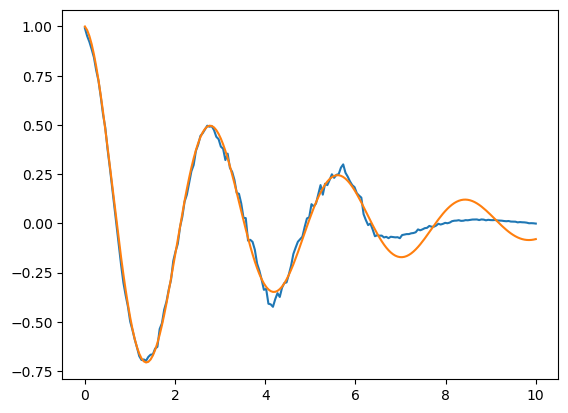

In [23]:
plt.plot(t_ques, x_pred_ans)
plt.plot(t_ques, x_true_ans)
plt.plot()

#Denoising using Autoencoder

In [ ]:
variational_autoencoder = VAE(encoder, decoder, beta_rec=10., beta_kl=1)
variational_autoencoder.compile(optimizer='adam')
variational_autoencoder.fit(x_train_reshaped, x_train_reshaped, batch_size=128, epochs=10)

In [ ]:
latent_z_mu, latent_z_logvar, x_prediction_reshaped = variational_autoencoder.predict(x_test_reshaped)

Let us introduce some noise to the images and see how the autoencoder performs on the noised images.

In [ ]:
#create noises for the training and test datasets as random values
train_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_train_reshaped.shape[1]))
test_noise = np.random.uniform(low=-0.7, high=0.7, size=(1, x_test_reshaped.shape[1]))

In [ ]:
#add the noise
x_train_noise = x_train_reshaped + train_noise
x_test_noise = x_test_reshaped + test_noise
#clip the noise in the range [0,1]
x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

We see that the encoder is performing badly for the noised data. This is because the encoder is not trained to remove the noise. So, lets pass the encoder noised data and train it to produce denoised images.